
The REINFORCE Algorithm is one of the most Policy Gradient algorithms in renforcement learning
Policy gradient algorithms directly diffierintate the RL objective 
$$ J(\theta) = \mathop{\mathbb{E}}_{\pi_{\theta}}{[\sum_{t=1}^T}r(s_t,a_t)] $$
from the definitation of Expectation 
$$J(\theta) = \int \pi_\theta(a_t|s_t) \sum_{t=1}^Tr(s_t,a_t)  {d}(P(a_t|s_t) $$
This objective can be defferinated to be 
$$\nabla_\theta J(\theta) =\int \nabla_\theta \pi_\theta(a_t|s_t) \sum_{t=1}^Tr(s_t,a_t) {d}(P(a_t|s_t) $$
We know from calculus that 
$${d}\log{n} = \frac{{d}n}{n}$$
Hence the policy gradient is
$$\nabla_\theta J(\theta) =\int  \pi_\theta(a_t|s_t) \nabla_\theta \log {\pi_\theta(a_t|s_t)} \sum_{t=1}^Tr(s_t,a_t) {d}(P(a_t|s_t) $$
Which can be written as Expectation
$$\nabla_\theta J(\theta)  = \mathop{\mathbb{E}}_{\pi_{\theta}}[\nabla_\theta \log {\pi_\theta(a_t|s_t)}\sum_{t=1}^Tr(s_t,a_t)] $$

From a practicial point of view the general structre of any Reinfrocement learning algorithm is shown below
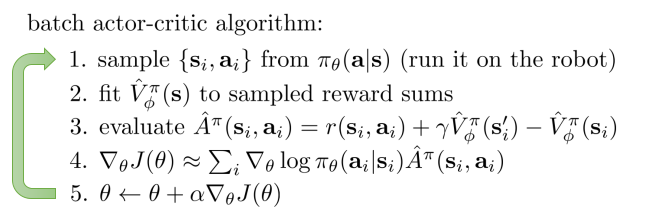 
for this vareint of REINFORCE algorithms the strcure will be </br >  
1. Generate Data by running the most recent policy, specifically this step should return states, rewards, and actions for each batch of training episode
2. Return estimation will implement Monte Carlo policy evaluation with discount factos causality 
$$ \hat{Q}(s_t,a_t) = \sum_{{t'}=t}^T r(s_{t'},a_{t'})$$
3. In this step 

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import numpy as np

from torch.utils.tensorboard import SummaryWriter

In [4]:
# cartpole problem with discrete actions
# Network archetacture

class SampleGeneration():
    @staticmethod
    @torch.no_grad()
    def generate_samples(network, env='CartPole-v0', N=4):
        states_N = []
        actions_N = []
        rewards_N = []
        env = gym.make(env)
        for trajectory in range(N):
            state = env.reset()
            states_N.append(state)
            rewards = []
            done = False
            while not done:
                state_t = torch.tensor(state.astype(np.float32)).unsqueeze(0)
                action_logits = network(state_t)
                actions_prob = network.softmax(action_logits)
                action = torch.multinomial(actions_prob, 1).item()
                actions_N.append(action)
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                if not done:
                    states_N.append(state)
            rewards_N.append(np.array(rewards))
            state_stack = np.stack(states_N)
        return (state_stack, rewards_N, np.array(actions_N))

In [5]:
# create Network
class Actor_Network(nn.Module):
    def __init__(self):
        super(Actor_Network, self).__init__()
        
        self.fc1 = nn.Linear(in_features=4, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, x):
        # layer 1
        x = F.relu(self.fc1(x))
        # layer 2
        x = F.relu(self.fc2(x))
        # output layer
        x = self.out(x)
        return x
    def softmax(self, logits):
        return F.softmax(logits, dim=1)

In [6]:
# create Network
class Critic_Network(nn.Module):
    def __init__(self):
        super(Critic_Network, self).__init__()
        
        self.fc1 = nn.Linear(in_features=4, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        # layefile:///home/faisal/Documents/ML%20practice/Deep%20Learning/pytorch/REINFORCE/REINFORCE.ipynbr 1
        x = F.relu(self.fc1(x))
        # layer 2
        x = F.relu(self.fc2(x))
        # output layer
        x = self.out(x)
        return x
    def softmax(self, logits):
        return F.softmax(logits, dim=1)

In [5]:
def list_to_torch_tensor(List):
    l = []
    for element in List:
        for r in element:
            l.append(r)
    return torch.tensor(l, dtype=torch.float32)

In [6]:
@torch.no_grad()
def n_step_TD(net,states,rewards,n):
    res = []
    gamma = 0.99
    T = len(rewards)
    for t in range(T):
        sum_r = 0
        taw = t - n
        if taw < 0:
            res.append(rewards[t])
        if taw >= 0:
            for i in range(taw,min(taw+n,T)):
                sum_r += (gamma**(i-taw) * rewards[i])
            if (taw+n) < T:
                sum_r += gamma**n * net(torch.tensor(states[taw+n], dtype=torch.float32)).item()
            res.append(sum_r)
    res.reverse()
    return res

In [7]:
class ReturnEstimator():
    # reward_to_go
    @staticmethod
    def estimate_return(rewards):
        gamma = 0.99
        res = [[] for i in range(len(rewards))]
        for i in range(len(rewards)):
            sum_r = 0.0
            for r in rewards[i]:
                sum_r *= gamma
                sum_r += r
                res[i].append(sum_r)
            res[i].reverse()
        return np.array(res)
    @staticmethod
    def n_step_batach(net,states,rewards_n,n):
        res = []
        for i in range(len(rewards_n)):
            if i == 0:
                cur_states = states[i:len(rewards_n[i])]
            else:
                cur_states = states[len(rewards_n[i-1]):len(rewards_n[i])+len(rewards_n[i-1])]
            res.append(n_step_TD(net,cur_states,rewards_n[i],n))
        return np.array(res)
    @staticmethod
    def fit_v(net, states, targets, opt, tb, step):
        states_t = torch.tensor(states,dtype=torch.float32)
        targets_t = list_to_torch_tensor(targets)
        opt.zero_grad()
        preds = net(states_t)
        loss = F.mse_loss(preds.squeeze(1), targets_t)
        tb.add_scalar('val_loss', loss, step)
#         print(loss)
        loss.backward()
        opt.step()
    @torch.no_grad()
    def calc_adv(net, targets, states):
        states_t = torch.FloatTensor(states)
        targets_t = list_to_torch_tensor(targets)
        values = net(states_t)
        adv = targets_t - values
        return adv
    @torch.no_grad()
    def calc_adv_from_rewards(value_net,rewards,states, gamma=0.99):
        advs = []
        for i in range(len(rewards)):
            eps_len = len(rewards[i])
            last_state_reward = rewards[i][-1]
#             rewards_n = np.array(rewards[i][:-1], dtype=np.float32)
            rewards_t = torch.tensor(np.array(rewards[i][:-1]), dtype=torch.float32)
            if i == 0:
                cur_states = states[i:len(rewards[i])]
            else:
                cur_states = states[len(rewards[i-1]):len(rewards[i])+len(rewards[i-1])]
#             print(next_states_t.shape)
            states_t = torch.FloatTensor(cur_states[0:eps_len-1])
            next_states_t = torch.FloatTensor(cur_states[1:eps_len])
            states_values_t = value_net(states_t)
            next_states_values_t = value_net(next_states_t)
            rewards_t = rewards_t.reshape(-1,1)
            adv_t = (rewards_t + (gamma * next_states_values_t)) - states_values_t
            print(adv_t.shape)
            adv_n = adv_t.detach().numpy().tolist()
            adv_n.append([last_state_reward])
            advs.append(adv_n)
        return np.array(advs)

In [8]:
def improve_policy(network, states, adv, actions, optimizer, tb, step):
    
    optimizer.zero_grad()
    states_t = torch.tensor(states, dtype=torch.float32)
    tb.add_scalar('adv',torch.mean(adv),step)
    logits = network(states_t)
    actions_log_probs = F.log_softmax(logits, dim=1)
    selected_actions_log_probs_t = actions_log_probs[range(len(actions_log_probs)), actions]
#     print(q_t)
    loss = selected_actions_log_probs_t * adv
    loss = -loss.mean()
#     print(loss)
    tb.add_scalar('loss', loss, step)
    loss.backward()
    optimizer.step()

In [7]:
@torch.no_grad()
def test_policy(network, env="CartPole-v0", render=False, record=False):
    runs = 5
    total_reward = 0.0
    env = gym.make(env)
    if record:
        env = gym.wrappers.Monitor(env, "recording")
    for run in range(runs):
        state = env.reset()
        done = False
        while not done:
            if render:
                env.render()
            state_t = torch.tensor(state, dtype=torch.float32)
            action_logits = network(state_t)
            action = action_logits.argmax(dim=0).item()
            state, reward, done, _ = env.step(action)
            total_reward += reward
    env.close()
    return total_reward / runs

In [40]:
policy = Actor_Network()
critic = Critic_Network()
states, rewards, actions = SampleGeneration.generate_samples(policy, N=4)
tb = SummaryWriter(comment=f"-lr={lr}")
# tb.add_graph(policy, states)
sum_rewards = ReturnEstimator.estimate_return(rewards)
ReturnEstimator.fit_v(critic, states, sum_rewards, crt_optimizer, tb, i)
ReturnEstimator.calc_adv_from_rewards(critic, rewards, states)
len(rewards[0])

torch.Size([16, 1])
torch.Size([14, 1])
torch.Size([15, 1])
torch.Size([30, 1])


17

In [10]:
# policy imporvment
# hyperparameters
seeds = [1,4,10,42]
episodes_num = 30000
N = 4
save_path = '/home/faisal/Documents/ML practice/Deep Learning/pytorch/REINFORCE/policy.pt'
#######
env = 'CartPole-v0'
rewards_100 = []
lrs = [0.001, 0.00001, 0.000001]
for lr in lrs:
    policy = Actor_Network()
    critic = Critic_Network()
    tb = SummaryWriter(comment=f"-lr={lr}")
    states = torch.tensor(gym.make(env).reset(), dtype=torch.float32)
    tb.add_graph(policy, states)
    print(policy)
    act_optimizer = opt.Adam(policy.parameters(), lr=lr)
    crt_optimizer = opt.Adam(critic.parameters(), lr=lr)
    for i in range(episodes_num):
        # run the policy
        states, rewards, actions = SampleGeneration.generate_samples(policy, N=N)
        # estimate the return
        td_targets = ReturnEstimator.n_step_batach(critic, states, rewards,6)
#         sum_rewards = ReturnEstimator.estimate_return(rewards)
        ReturnEstimator.fit_v(critic, states, td_targets, crt_optimizer, tb, i)
#         adv = ReturnEstimator.calc_adv(critic, rewards, states)
#         adv = list_to_torch_tensor(adv)
        adv = ReturnEstimator.calc_adv(critic, td_targets, states)
        # imporove the polciy
        improve_policy(policy, states, adv, actions, act_optimizer, tb, i )
        # test the policy
        test_reward = test_policy(policy)
        rewards_100.append(test_reward)
        tb.add_scalar('reward', test_reward, i)

        if len(rewards_100) >= 100:
            reward_100 = sum(rewards_100) / 100.0
            tb.add_scalar('reward_100', reward_100, i)
            if reward_100 > 190:
                torch.save(policy.state_dict(), save_path)
            rewards_100 = []
        for name, param in policy.named_parameters():
            tb.add_histogram(f'{name}', param, i)
            tb.add_histogram(f'{name}.grad', param.grad, i)

/home/faisal/anaconda3/envs/torch/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Actor_Network(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)


KeyboardInterrupt: 

In [8]:
save_path = '/home/faisal/Documents/ML practice/Deep Learning/pytorch/REINFORCE/policy.pt'
actor = Actor_Network()
actor.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [10]:
test_policy(actor,render=True, record=True)

200.0